In [ ]:
# Parameters
run = "06_hd_reg"
base_folder = "artificial_humans"
target = "contributions"


In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

data_folder = os.path.join('../../data', base_folder, run)
plot_folder = f'plots/{base_folder}_{run}'

make_dir(plot_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def _plot_heatmap(data, x, y, values, normalise=True):
    dfg = data.groupby([x,y])[values].sum()
    dfg = dfg.reset_index()
    if normalise:
        dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    cm = cm.sort_index(ascending=False)
    sns.heatmap(cm)

def merge_data(data_folder, metric_name):
    folder = os.path.join(data_folder, metric_name)
    dfs = [pd.read_parquet(os.path.join(folder, file)) for file in os.listdir(folder)]
    df = pd.concat(dfs).reset_index(drop=True)
    return df


In [4]:
metrics_df = merge_data(data_folder, 'metrics')
print(metrics_df['cv_split'].unique())
confusion_matrix_df = merge_data(data_folder, 'confusion_matrix')
metrics_df['shuffle_feature'] = metrics_df['shuffle_feature'].fillna('none')
labels = list(set(metrics_df.columns) - set(['job_id', 'name', 'value', 'cv_split', 'epoch', 'set', 'strategy', 'shuffle_feature']))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]


: 

: 

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


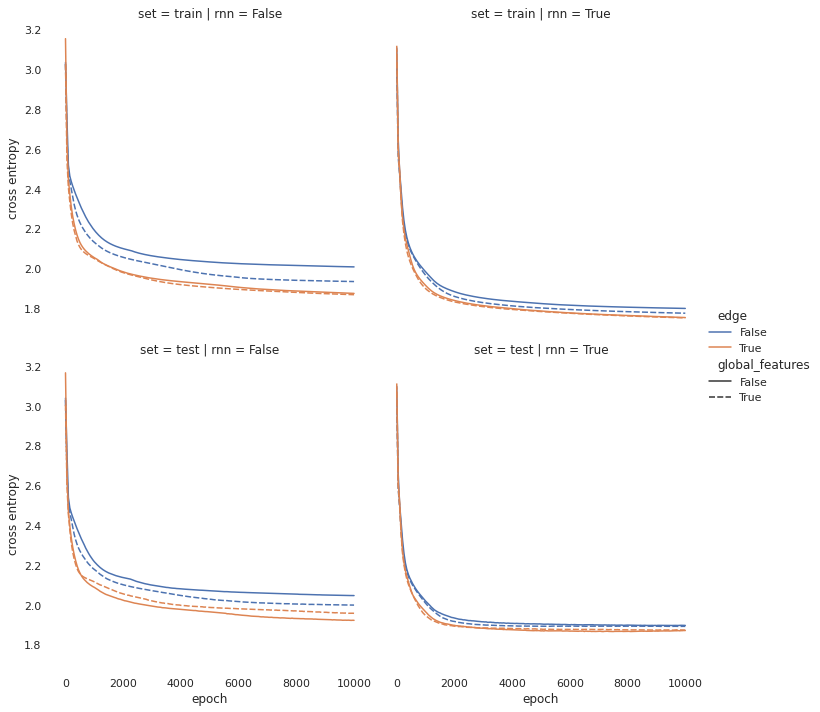

In [ ]:
df = metrics_df.copy()


focus = [*labels, 'set']

sel = {
    'name': 'log_loss',
    'shuffle_feature': 'none',
}

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in sel.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)

df = df[w]

fg = sns.relplot(
    data=df, 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)

fg.set(ylabel='cross entropy')

fg.savefig(os.path.join(plot_folder, 'learning_curve_model.jpg'))

In [ ]:
import statsmodels.formula.api as smf


df = metrics_df.copy()

w = (
    (df['name'] == 'log_loss') &
    (df['set'] == 'test') &
    (df['shuffle_feature'] == 'none')
)
df = df[w].copy()
w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
df = df[w_max].copy()

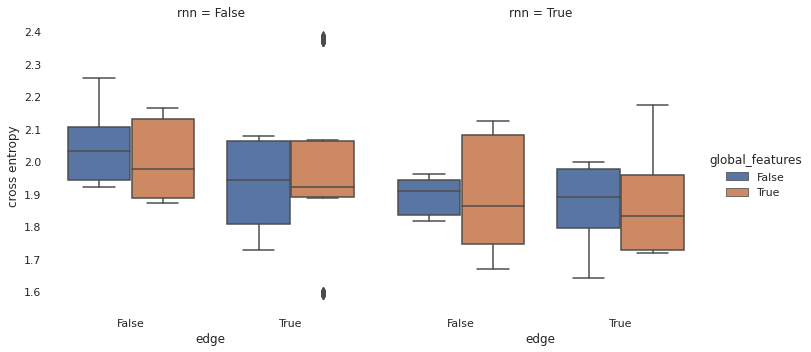

In [ ]:
df = metrics_df.copy()

focus = labels

w = (
    (df['name'] == 'log_loss') &
    (df['set'] == 'test') &
    (df['shuffle_feature'] == 'none')
)
df = df[w].copy()
w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
df = df[w_max].copy()


fg = sns.catplot(
    data=df, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box')

fg.set(ylabel='cross entropy')

fg.savefig(os.path.join(plot_folder, 'cross_entropy_box.jpg'))

/tmp/ipykernel_9157/1743355618.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  coef_df['Treatment'] = coef_df['Treatment'].str.replace('\[T.True\]', '')


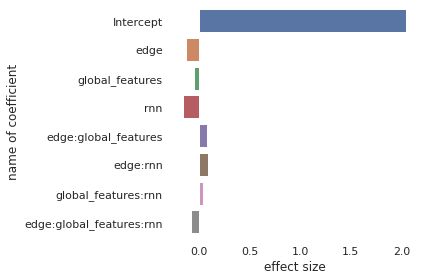

In [ ]:
import statsmodels.formula.api as smf


df = metrics_df.copy()

w = (
    (df['name'] == 'log_loss') &
    (df['set'] == 'test') &
    (df['shuffle_feature'] == 'none')
)
df = df[w].copy()
w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
df = df[w_max].copy()


dfg = df.groupby(labels+['cv_split'])['value'].mean().reset_index()

coef = smf.glm(f"value ~ {'*'.join(labels)}", data=dfg).fit()
coef_df = coef.summary2().tables[1].reset_index()
# coef_df.sort_values('P>|z|')
coef_df = coef_df.rename(columns={'index': 'Treatment', 'Coef.': 'Coefficient'})
coef_df['Treatment'] = coef_df['Treatment'].str.replace('\[T.True\]', '')
# coef_df = coef_df[coef_df['Treatment'] != 'Intercept']
fg = sns.barplot(data=coef_df, y='Treatment', x='Coefficient')

fg.set(ylabel='name of coefficient', xlabel='effect size')

plt.tight_layout()

plt.savefig(os.path.join(plot_folder, 'effect_size.jpg'))

coef_df.to_markdown(os.path.join(plot_folder, 'effect_size.md'))